# Panel Data Analysis

Authors: Antonio Puzalkov, Gabriele Gabrielli

## Preprocessing

### Load the Data:

In [48]:
import pandas as pd
import unicodedata
import re

price_per_NIL_dict = pd.read_excel("Panel Data/Dati Storici.xlsx", sheet_name=None)
def clean_sheet_prices(sheet):
    sheet["Prezzo m2"] = sheet["Prezzo m2"].str.replace(' €/m2', '', regex=False)
    sheet["Prezzo m2"] = sheet["Prezzo m2"].str.replace('.', '', regex=False)
    sheet["Variazione mensile"] = sheet["Variazione mensile"].str.replace(' %', '', regex=False)
    sheet["Variazione trimestrale"] = sheet["Variazione trimestrale"].str.replace(' %', '', regex=False)
    sheet["Variazione annuale"] = sheet["Variazione annuale"].str.replace(' %', '', regex=False)
    sheet["Variazione mensile"] = sheet["Variazione mensile"].str.replace(' ', '', regex=False)
    sheet["Variazione trimestrale"] = sheet["Variazione trimestrale"].str.replace(' ', '', regex=False)
    sheet["Variazione annuale"] = sheet["Variazione annuale"].str.replace(' ', '', regex=False)
        
    def clean_number_prices(x):
        if isinstance(x, str):
            return float(x.replace(',', '.').replace('+', '').strip())
        return x

    for col in ["Variazione mensile", "Variazione trimestrale", "Variazione annuale"]:
        sheet[col] = sheet[col].apply(clean_number_prices)
    
    sheet["Prezzo m2"] = pd.to_numeric(sheet["Prezzo m2"])
    sheet["Variazione mensile"] = pd.to_numeric(sheet["Variazione mensile"])
    sheet["Variazione trimestrale"] = pd.to_numeric(sheet["Variazione trimestrale"])
    sheet["Variazione annuale"] = pd.to_numeric(sheet["Variazione annuale"])
    return sheet  

for dataset in price_per_NIL_dict.values():
    if "Prezzo m2" in dataset.keys():
        dataset = clean_sheet_prices(dataset)
    else:
        pass

# Converts the dict to a single sheet --> tbd if to be removed or not
all_sheets = []
for name, sheet in price_per_NIL_dict.items():
    if name.lower() == "explanation":
        continue
    
    sheet['NIL'] = name
    sheet = sheet.rename(columns=lambda x: x.split('/n')[-1])
    all_sheets.append(sheet)

prices_full_table = pd.concat(all_sheets)
prices_full_table.reset_index(inplace=True, drop=True)
Legend = pd.read_excel("Panel Data/Legend_updated.xlsx")
prices_full_table = prices_full_table[prices_full_table["NIL"] != "Milano"].copy()
Legend = Legend.drop("Milano", axis=1)
health_care_data = pd.read_csv("Panel Data/Sanità/geocoded_batch_ds683_posti_letto_strutture_milano_final.csv", sep=";", encoding="Latin-1")



In [50]:
health_care_data.keys()

Index(['Anno', 'Codice Azienda', 'Tipo Azienda', 'Codice struttura',
       'Subcodice', 'Denominazione Struttura/Stabilimento', 'Indirizzo',
       'Codice tipo struttura', 'Descrizione tipo struttura',
       'Codice disciplina', 'Descrizione disciplina', 'Tipo di Disciplina',
       'N Reparti', 'Posti letto degenza ordinaria',
       'Posti letto degenza a pagamento', 'Posti letto Day Hospital',
       'Posti letto Day Surgery', 'Totale posti letto', 'address_MI', 'CAP',
       'MUNICIPIO', 'ID_NIL', 'NIL', 'LONG_X_4326', 'LAT_Y_4326', 'Location'],
      dtype='object')

In [51]:
health_remove = ['Tipo Azienda',
 'Codice struttura',
 'Subcodice',
 'Codice tipo struttura',
 'Codice disciplina',
 'Descrizione disciplina',
 'Posti letto Day Surgery',
 'Posti letto Day Hospital',
 'Posti letto degenza a pagamento',
 'Posti letto degenza ordinaria',
 'address_MI',
 'ID_NIL',
 'LONG_X_4326',
 'LAT_Y_4326',
 'Location']

health_keep = ['Anno',
               'CAP',
               "MUNICIPIO",
               "NIL",
               "Totale posti letto",
               "N Reparti",
               "Tipo di Disciplina"
               ]
health_care_data = health_care_data[health_keep]
inflation = pd.read_excel("Panel Data/Controlli/TassoInflazioneMilano_da_2000.xlsx", header=4).iloc[:,:2]
inflation.rename(columns={"Variazione percentuale tendenziale/n MEDIA ANNUA":"Variazione Annuale"})
cancellazioni_anagrafe = pd.read_excel("Panel Data/Popolazione/CANCELLAZIONI DA ANAGRAFE A MILANO - DATA EVENTO (2004-2022).xlsx")
decessi_anagrafe = pd.read_excel("Panel Data/Popolazione/DECESSI DEI RESIDENTI A MILANO (2003-2023).xlsx")
famiglie_anagrafe = pd.read_csv("Panel Data/Popolazione/FAMIGLIE REGISTRATE IN ANAGRAFE - ANNO.csv", sep=";", encoding='latin-1')
cittadinanza =pd.read_csv("Panel Data/Popolazione/Cittadinanza_2_tipip.csv", sep=";", encoding='latin-1')
popolazione =pd.read_csv("Panel Data/Popolazione/residenti_per-_nil_serie_storica.csv", sep=";", encoding='latin-1')

## Analysis

In [63]:
cancellazioni_anagrafe.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Anno,2004.000,2005.00,2006.000,2007.000,2008.000,2009.000,2010.000,2011.000,2012.000,2013.000,2014.00,2015.000,2016.000,2017.00,2018.000,2019.000,2020.000,2021.000,2022.000
Duomo (1),673.000,612.00,632.000,630.000,551.000,497.000,479.000,482.000,681.000,1.059,809.00,496.000,540.000,640.00,585.000,534.000,600.000,620.000,608.000
Brera (2),596.000,613.00,660.000,556.000,512.000,492.000,495.000,535.000,595.000,891.000,957.00,629.000,631.000,632.00,541.000,529.000,569.000,650.000,548.000
Giardini P.ta Venezia (3),5.000,2.00,1.000,1.000,0.000,1.000,0.000,5.000,1.000,5.000,6.00,1.000,0.000,0.00,0.000,0.000,6.000,0.000,0.000
Guastalla (4),455.000,432.00,451.000,414.000,363.000,323.000,363.000,351.000,437.000,717.000,596.00,422.000,412.000,352.00,368.000,314.000,395.000,468.000,411.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Parco dei Navigli (86),30.000,15.00,18.000,26.000,18.000,22.000,23.000,14.000,17.000,19.000,14.00,13.000,19.000,22.00,11.000,17.000,17.000,15.000,19.000
Assiano (87),11.000,2.00,11.000,7.000,7.000,8.000,17.000,32.000,21.000,6.000,15.00,18.000,44.000,24.00,9.000,22.000,24.000,59.000,15.000
Parco Bosco in citta' (88),10.000,22.00,47.000,66.000,53.000,57.000,44.000,218.000,158.000,51.000,27.00,30.000,87.000,4.00,10.000,13.000,13.000,22.000,9.000
n.d.,1.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,1.000,1.000,0.00,0.000,0.000,0.000,0.000,0.000


In [54]:
_Legend = Legend.to_dict()
Legend_dict = {}
for key, each in _Legend.items():
    _list = []
    for n in each.values():
        if type(n) == str:
            _list.append(n)
            m = n.split("-")
            for item in m:
                _list.append(item)
    Legend_dict[key]=_list


def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove accents
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    # Remove special characters
    text = re.sub(r"[^\w\s-]", '', text)
    # Strip leading/trailing whitespace
    text = text.strip()
    return text

def generate_substrings(nil_normalized):
    substrings = set()
    hyphen_splits = nil_normalized.split('-')
    for part in hyphen_splits:
        part = part.strip()
        substrings.add(part)
        space_splits = part.split()
        for word in space_splits:
            substrings.add(word)
    return substrings


def find_macroarea_from_substrings(nil_normalized):
    substrings = generate_substrings(nil_normalized)
    macroarea_counts = {}
    for substring in substrings:
        if substring in nil_to_macroarea:
            macroarea = nil_to_macroarea[substring]
            macroarea_counts[macroarea] = macroarea_counts.get(macroarea, 0) + 1
    if macroarea_counts:
        # Assign the MacroArea with the highest count
        assigned_macroarea = max(macroarea_counts, key=macroarea_counts.get)
        return assigned_macroarea
    else:
        return None
    
    
nil_to_macroarea = {}
for macroarea, nil_list in Legend_dict.items():
    for nil in nil_list:
        nil_normalized = normalize_text(nil)
        nil_to_macroarea[nil_normalized] = macroarea
        
health_care_data['NIL_normalized'] = health_care_data['NIL'].astype(str).apply(normalize_text)
health_care_data['NIL_normalized'] = health_care_data['NIL'].astype(str).str.strip().str.lower()
health_care_data['MacroArea'] = health_care_data['NIL_normalized'].map(nil_to_macroarea)

mask = health_care_data['MacroArea'].isna()
health_care_data.loc[mask, 'MacroArea'] = health_care_data.loc[mask, 'NIL_normalized'].apply(find_macroarea_from_substrings)




## Descriptive:

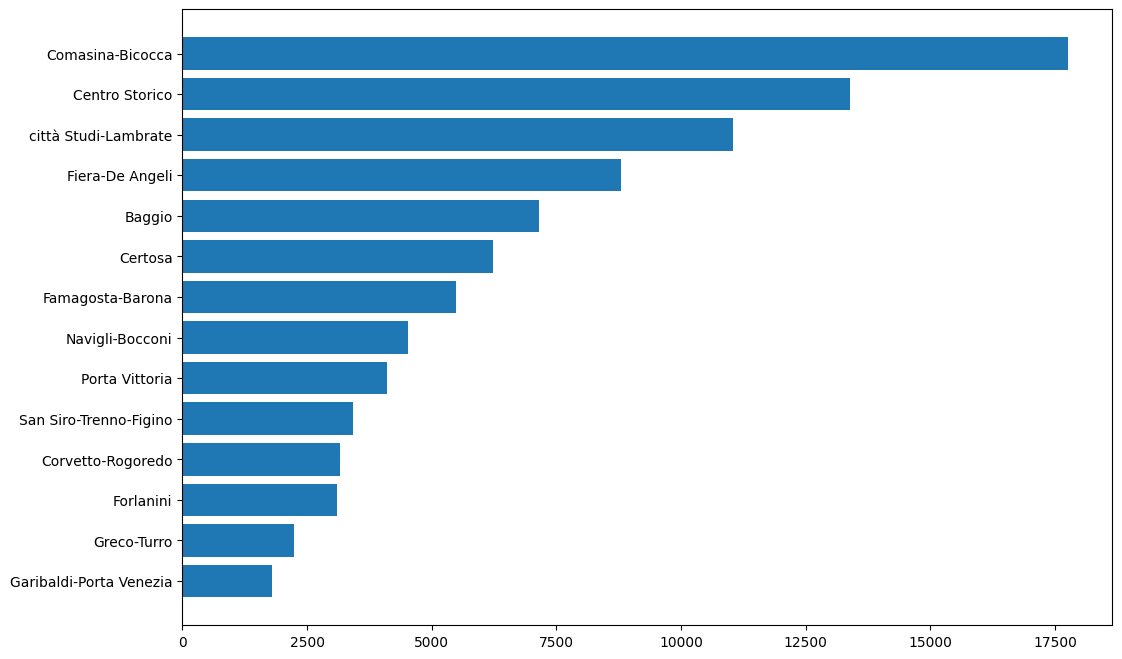

In [59]:
import matplotlib.pyplot as plt
summary_health = health_care_data.groupby("MacroArea").sum()
summary_health = summary_health.sort_values(by="Totale posti letto", ascending=True).reset_index()
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(summary_health["MacroArea"],summary_health["Totale posti letto"])
plt.show()

In [60]:
health_care_data["NIL"].unique()

array(['DUOMO', 'BRERA', 'GUASTALLA', 'PORTA VIGENTINA - PORTA LODOVICA',
       'MAGENTA - S. VITTORE', 'PAGANO', 'PADOVA - TURRO - CRESCENZAGO',
       'CIMIANO - ROTTOLE - Q.RE FELTRE', 'città STUDI', 'XXII MARZO',
       'PTA ROMANA', "MONLUE' - PONTE LAMBRO", 'PARCO DELLE ABBAZIE',
       'BARONA', 'PORTA MAGENTA', 'FORZE ARMATE', 'SAN SIRO',
       'DE ANGELI - MONTE ROSA', 'STADIO - IPPODROMI', 'QUARTO CAGNINO',
       'SARPI', 'VILLAPIZZONE - CAGNOLA - BOLDINASCO', 'ROSERIO', 'ISOLA',
       "NIGUARDA - CA' GRANDA - PRATO CENTENARO - Q.RE FULVIO TESTI",
       'BICOCCA', 'BRUZZANO'], dtype=object)

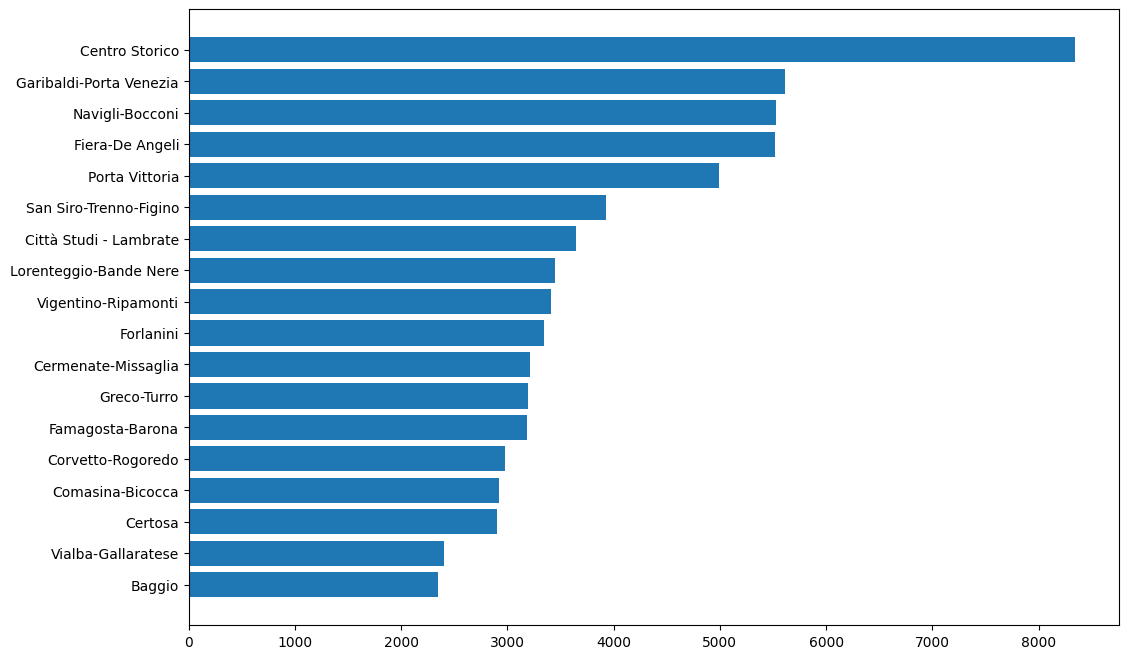

In [61]:
summary_prices = prices_full_table.groupby(by="NIL").mean()
summary_prices = summary_prices.sort_values(by="Prezzo m2", ascending=True).reset_index()
fig, ax = plt.subplots(figsize=(12,8))
ax.barh(summary_prices["NIL"], summary_prices["Prezzo m2"])
plt.show()